In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
orders=pd.read_csv('/content/drive/MyDrive/ml_project/orders.csv')
orders.head()
#print(orders.info(memory_usage='deep')) i can use also orders.info() in general

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [3]:
orders['order_id']=orders['order_id'].astype('int32')
orders['user_id']=orders['user_id'].astype('int32')
orders['order_number']=orders['order_number'].astype('int8')
orders['eval_set']=orders['eval_set'].astype('category')

In [4]:
orders['days_since_prior_order']=orders['days_since_prior_order'].fillna(0)
#orders.head()
orders=orders.drop_duplicates()

to handle the missing value in the days since prior order column we did the imputation, because the missing value (NaN) happens when there isn't a previous order that exists to calculate the time gap, then we dropped the duplicated columns to make sure the data is clean.

In [5]:
order_prior = pd.read_csv('/content/drive/MyDrive/ml_project/order_products__prior.csv')

In [6]:
order_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [7]:
order_prior['order_id']=order_prior['order_id'].astype('int32')
order_prior['product_id']=order_prior['product_id'].astype('int32')
order_prior['reordered']=order_prior['reordered'].astype('int8')

since RAM has a certain limit we have to downcast due to large dataset size

In [8]:
order_prior.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 4 columns):
 #   Column             Dtype
---  ------             -----
 0   order_id           int32
 1   product_id         int32
 2   add_to_cart_order  int64
 3   reordered          int8 
dtypes: int32(2), int64(1), int8(1)
memory usage: 525.8 MB


In [9]:
order_prior=order_prior[['order_id','product_id','reordered']]

In [10]:
products_per_order =(order_prior.groupby('order_id').size().reset_index(name='num_products'))

In [11]:
orders =orders.merge(products_per_order,on='order_id',how='left')

In [12]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,num_products
0,2539329,1,prior,1,2,8,0.0,5.0
1,2398795,1,prior,2,3,7,15.0,6.0
2,473747,1,prior,3,3,12,21.0,5.0
3,2254736,1,prior,4,4,7,29.0,5.0
4,431534,1,prior,5,4,15,28.0,8.0


In [13]:
orders[['order_dow','order_hour_of_day','num_products']].describe()

,order_dow,order_hour_of_day,num_products
count,3.421083e+06,3.421083e+06,3.214874e+06
mean,2.776219e+00,1.345202e+01,1.008888e+01
std,2.046829e+00,4.226088e+00,7.525398e+00
min,0.000000e+00,0.000000e+00,1.000000e+00
25%,1.000000e+00,1.000000e+01,5.000000e+00
50%,3.000000e+00,1.300000e+01,8.000000e+00
75%,5.000000e+00,1.600000e+01,1.400000e+01
max,6.000000e+00,2.300000e+01,1.450000e+02


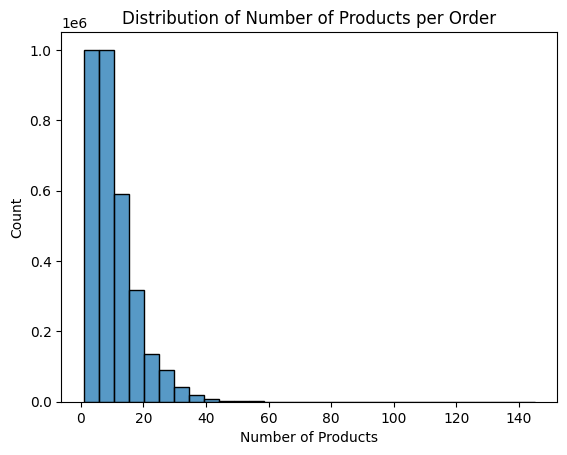

In [14]:
plt.figure()
sns.histplot(orders['num_products'], bins=30)
plt.title('Distribution of Number of Products per Order')
plt.xlabel('Number of Products')
plt.ylabel('Count')
plt.show()

The majority of orders contain a small number of products,with a right skewed distribution.This indicates that most customers place small orders, while large orders are relatively rare.



In [15]:
reorder_rate_per_order =(order_prior.groupby('order_id')['reordered'].mean().reset_index(name='reorder_rate'))

In [16]:
orders = orders.merge(reorder_rate_per_order, on='order_id', how='left')

In [17]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,num_products,reorder_rate
0,2539329,1,prior,1,2,8,0.0,5.0,0.000
1,2398795,1,prior,2,3,7,15.0,6.0,0.500
2,473747,1,prior,3,3,12,21.0,5.0,0.600
3,2254736,1,prior,4,4,7,29.0,5.0,1.000
4,431534,1,prior,5,4,15,28.0,8.0,0.625


In [18]:
orders['reorder_rate'].describe()

,reorder_rate
count,3.214874e+06
mean,5.986633e-01
std,3.379612e-01
min,0.000000e+00
25%,3.333333e-01
50%,6.666667e-01
75%,9.090909e-01
max,1.000000e+00


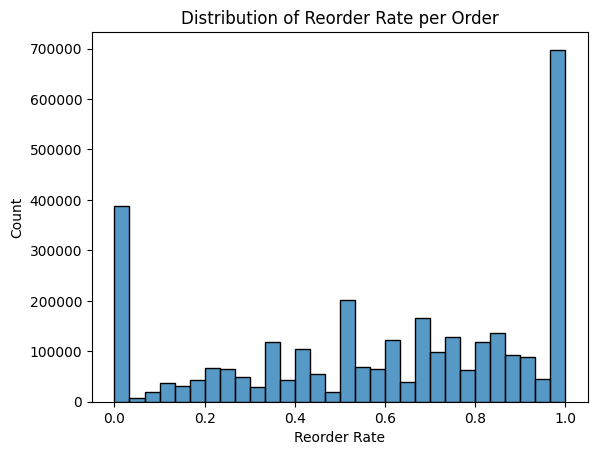

In [19]:
plt.figure()
sns.histplot(orders['reorder_rate'], bins=30)
plt.title('Distribution of Reorder Rate per Order')
plt.xlabel('Reorder Rate')
plt.ylabel('Count')
plt.show()


Most orders have a low reorder rate, indicating that many orders contain new products.However, a subset of orders shows high reorder rates, suggesting consistent purchasing behavior.


In [20]:
full_prior_orders=pd.merge(order_prior,orders,on='order_id',how='left')

In [21]:
full_prior_orders.head()

,order_id,product_id,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,num_products,reorder_rate
0,2,33120,1,202279,prior,3,5,9,8.0,9.0,0.666667
1,2,28985,1,202279,prior,3,5,9,8.0,9.0,0.666667
2,2,9327,0,202279,prior,3,5,9,8.0,9.0,0.666667
3,2,45918,1,202279,prior,3,5,9,8.0,9.0,0.666667
4,2,30035,0,202279,prior,3,5,9,8.0,9.0,0.666667


In [22]:
full_prior_orders.to_csv('/content/drive/MyDrive/ml_project/full_prior_orders.csv',index=False)